In [1]:
import sys
import glob
import os
import pandas as pd
import ee
import numpy as np
import geopandas as gp

import matplotlib.pyplot as plt
import rsfuncs as rs

from scipy import stats
from scipy.signal import savgol_filter
from datetime import datetime, timedelta
from datetime import datetime as dt

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [18,16]
ee.Initialize()

In [2]:
# Read data

In [3]:
states_file = gp.read_file("../shape/states.shp")
states = states_file[~states_file['STATE_ABBR'].isin(["AK", "HI", "PR", "VI"])]

site_file = gp.read_file("../shape/scan_sites.shp")
sites = site_file[~site_file['state'].isin(["AK", "HI", "PR", "VI"])]

In [4]:
df = pd.read_csv("../data/all_dat_desc.csv")

In [5]:
df.rename(columns={ df.columns[0]: "site" }, inplace = True)
df.replace([np.inf, -np.inf], np.nan, inplace = True)

In [6]:
df = df.set_index(pd.to_datetime(df.date))

In [7]:
# Remove outliers
df = df[~(np.abs(df.psi_rz-df.psi_rz.mean()) > (df.psi_rz.std()))]

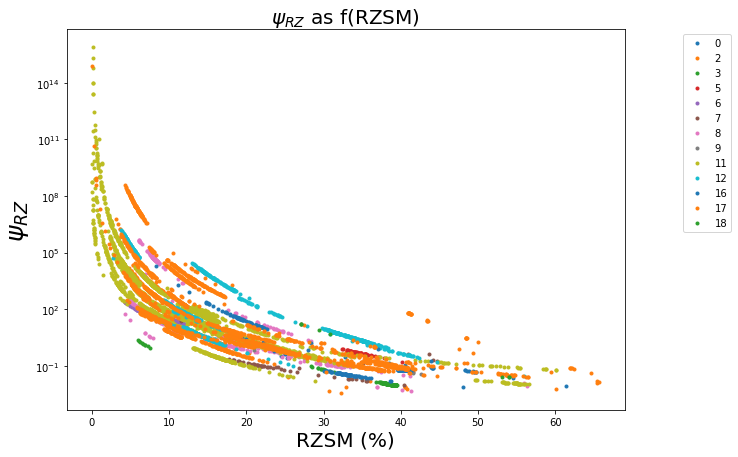

In [8]:
groups = df.groupby('lc_type')

fig, ax = plt.subplots(figsize=(10,7))

for name, group in groups:
    ax.plot(group.rzsm, group.psi_rz, marker='o', linestyle='', ms=3, label=name)
    
ax.legend(bbox_to_anchor=(1.2, 1))
ax.set_title("$\psi_{RZ}$ as f(RZSM)", size = 20)
ax.set_ylabel("$\psi_{RZ}$", size = 25)
ax.set_yscale("log")
ax.set_xlabel("RZSM (%)", size = 20)

plt.show()

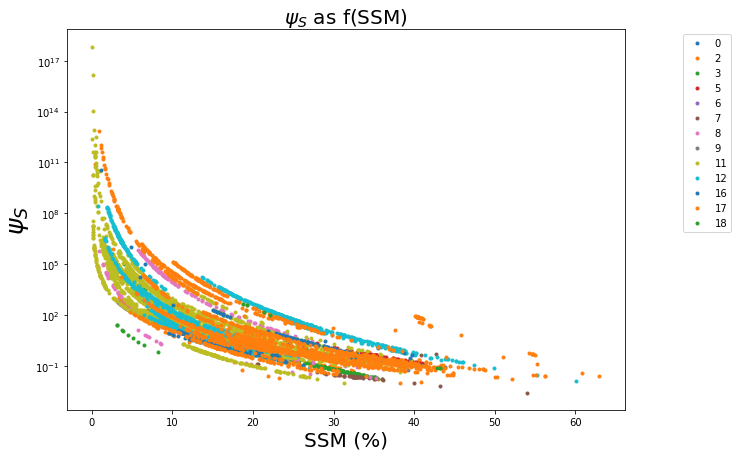

In [9]:
groups = df.groupby('lc_type')

fig, ax = plt.subplots(figsize=(10,7))

for name, group in groups:
    ax.plot(group.ssm, group.psi_s, marker='o', linestyle='', ms=3, label=name)
    
ax.legend(bbox_to_anchor=(1.2, 1))
ax.set_title("$\psi_{S}$ as f(SSM)", size = 20)
ax.set_ylabel("$\psi_{S}$", size = 25)
ax.set_yscale("log")
ax.set_xlabel("SSM (%)", size = 20)

plt.show()

In [10]:
site_lens = {}
for i in df.site.unique():
    sdf = df[df.site==i]
    site_lens[i] = (len(sdf))

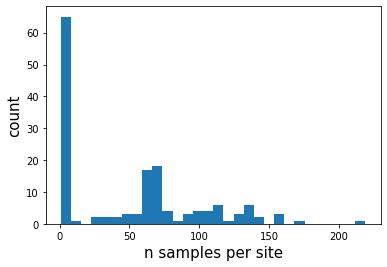

In [36]:
plt.hist(np.array(list(site_lens.values())), bins = 30)[-1]
plt.xlabel("n samples per site", size = 15)
plt.ylabel("count", size = 15)
plt.show()

In [29]:
t = pd.DataFrame.from_dict(list(site_lens.items()))
t.columns = ['site_id', 'len']
# t.set_index('site_id', inplace = True);

In [31]:
gdf = pd.merge(sites,t,how = "inner", left_index = True, right_index = True)

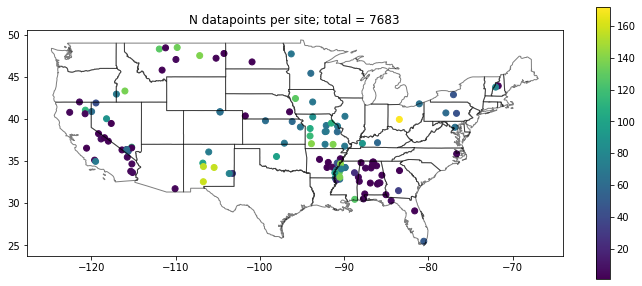

In [39]:
fig, ax = plt.subplots(figsize = (12,5))

ax.set_title("N datapoints per site; total = {}".format(sum(site_lens.values())))
gdf.plot(ax = ax, column = "len", legend = True)
states.plot(ax = ax, color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)
plt.show()

In [ ]:
plt.figure(figsize=(8,6))

plt.title('''$\sigma$ vs Soil moisture 
          n_overpasses: {}  
          startdate: {} 
          enddate: {}
          buffer size: {}m'''.format(len(dates), dates[0], dates[-1], "10"))

plt.xlabel("Backscatter ($\sigma$), dB")
plt.scatter(mean_sigmas, rzsm, label = 'rzsm')
plt.scatter(mean_sigmas, ssm, label = 'ssm')
plt.plot(x, intercept + slope*x, 'blue', label='rzsm y = {}x +{}, $r =$ {}'.format(round(slope,1), round(intercept,1), round(r_value,2)))
plt.xlabel("$\sigma$ (dB)")
plt.ylabel("Soil moisture (%)")
plt.legend()
plt.show()

In [ ]:
# as a timeseries

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,6))

plt.title('''$\sigma$ vs Soil moisture Time Series
          n_overpasses: {}  
          startdate: {} 
          enddate: {}
          buffer size: {}m'''.format(len(dates), dates[0], dates[-1], buffer_size))

color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel("$\sigma$ (dB)", color=color)
ax1.plot(dates, mean_sigmas, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('rzsm', color=color)  
ax2.plot(dates,rzsm,color = color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 

plt.show()

In [ ]:
# remove the days with high preceding rainfall 

In [ ]:
imageCollection = ee.ImageCollection("OREGONSTATE/PRISM/AN81d").filterBounds(area)

In [ ]:
def filter_date(product,y,m,d):
    start = ee.Date.fromYMD(y,m,d).advance(-1, "day")
    end = ee.Date.fromYMD(y,m,d)
    end = ee.Date.fromYMD(y,m,d)
    prod = product.filterDate(start, end).sort('system:time_start', False).select("ppt")
    return prod

def get_2day_precip(latlon_obj):
    res = latlon_obj.reduceRegion(reducer=ee.Reducer.sum(),geometry=area,scale=10)
    data = np.array((ee.Array(res.get("ppt")).getInfo()))
    out = np.array(data)
    return out 

In [ ]:
rainfall = []

for i,x in enumerate(dates):
    y,m,d = dates[i].year, dates[i].month, dates[i].day
    t = filter_date(imageCollection, y, m, d).sum()
    precip_total = get_2day_precip(t)
    rainfall.append(precip_total)

In [ ]:
fdf = pd.DataFrame([dates, mean_sigmas, rzsm, rainfall])

In [ ]:
fdf = fdf.T
fdf.columns = (['date', "sigma", "rzsm", "rainfall"])

In [ ]:
mask=(fdf['rainfall'] < 0.1)
asdf=fdf[mask]

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,6))

plt.title('''2 day sum Precip (mm) and Soil moisture (%) Time Series
          n_overpasses: {}  
          startdate: {} 
          enddate: {}
          buffer size: {}m'''.format(len(dates), dates[0], dates[-1], buffer_size))

color = 'tab:blue'
ax1.set_xlabel('date')
ax1.set_ylabel("Precip (mm)", color=color)
ax1.plot(dates, rainfall, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('rzsm', color=color)  
ax2.plot(dates,rzsm,color = color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 

plt.show()

In [ ]:
# Plot linear fit of sigma vs SM
x = np.array(asdf['sigma'])
x = x.reshape(x.shape[0]).astype(np.float32)
y = np.array(asdf['rzsm'])
y = y.reshape(y.shape[0]).astype(np.float32)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

plt.figure(figsize=(8,6))

plt.title('''$\sigma$ vs Soil moisture for overpasses without prior precipitation
          n_overpasses: {}  
          startdate: {} 
          enddate: {}
          buffer size: {}m'''.format(len(asdf), asdf['date'].min(), asdf['date'].max(), buffer_size))

plt.xlabel("Backscatter ($\sigma$), dB")
plt.scatter(asdf['sigma'],asdf['rzsm'], label = "rzsm")
# plt.scatter(mean_sigmas, ssm, label = 'ssm')
plt.plot(x, intercept + slope*x, 'blue', label='rzsm y = {}x +{}, $r =$ {}'.format(round(slope,1), round(intercept,1), round(r_value,2)))
plt.xlabel("$\sigma$ (dB)")
plt.ylabel("Soil moisture (%)")
plt.legend()
plt.show()

In [ ]:
# Let's test with 4 day precip accumulation

imageCollection = ee.ImageCollection("OREGONSTATE/PRISM/AN81d").filterBounds(area)

def filter_date(product,y,m,d):
    start = ee.Date.fromYMD(y,m,d).advance(-4, "day")
    end = ee.Date.fromYMD(y,m,d)
    end = ee.Date.fromYMD(y,m,d)
    prod = product.filterDate(start, end).sort('system:time_start', False).select("ppt")
    return prod

def get_2day_precip(latlon_obj):
    res = latlon_obj.reduceRegion(reducer=ee.Reducer.sum(),geometry=area,scale=10)
    data = np.array((ee.Array(res.get("ppt")).getInfo()))
    out = np.array(data)
    return out 

rainfall = []

for i,x in enumerate(dates):
    y,m,d = dates[i].year, dates[i].month, dates[i].day
    t = filter_date(imageCollection, y, m, d).sum()
    precip_total = get_2day_precip(t)
    rainfall.append(precip_total)
    

In [ ]:
fdf = pd.DataFrame([dates, mean_sigmas, rzsm, rainfall])
fdf = fdf.T
fdf.columns = (['date', "sigma", "rzsm", "rainfall"])
mask=(fdf['rainfall'] < 0.1)
asdf=fdf[mask]

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,6))

plt.title('''4 day sum Precip (mm) and Soil moisture (%) Time Series
          n_overpasses: {}  
          startdate: {} 
          enddate: {}
          buffer size: {}m'''.format(len(dates), dates[0], dates[-1], buffer_size))

color = 'tab:blue'
ax1.set_xlabel('date')
ax1.set_ylabel("3 day precipitation (mm)", color=color)
ax1.plot(dates, rainfall, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('rzsm', color=color)  
ax2.plot(dates,rzsm,color = color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 

plt.show()

In [ ]:
# Plot linear fit of sigma vs SM
x = np.array(asdf['sigma'])
x = x.reshape(x.shape[0]).astype(np.float32)
y = np.array(asdf['rzsm'])
y = y.reshape(y.shape[0]).astype(np.float32)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

plt.figure(figsize=(8,6))

plt.title('''$\sigma$ vs Soil moisture for overpasses without prior precipitation (4 days)
          n_overpasses: {}  
          startdate: {} 
          enddate: {}
          buffer size: {}m'''.format(len(asdf), asdf['date'].min(), asdf['date'].max(), buffer_size))

plt.xlabel("Backscatter ($\sigma$), dB")
plt.scatter(asdf['sigma'],asdf['rzsm'], label = "rzsm")
# plt.scatter(mean_sigmas, ssm, label = 'ssm')
plt.plot(x, intercept + slope*x, 'blue', label='rzsm y = {}x +{}, $r =$ {}'.format(round(slope,1), round(intercept,1), round(r_value,2)))
plt.xlabel("$\sigma$ (dB)")
plt.ylabel("Soil moisture (%)")
plt.legend()
plt.show()